# Drill: Fixing Assumptions

### Judging from the diagnostic plots, your data has a problem with both heteroscedasticity and multivariate non-normality. Use the cell(s) below to see what you can do to fix it.

In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900


###### Ignore the first column

In [3]:
data = data[['TV', 'Radio', 'Newspaper', 'Sales']]

In [4]:
# New DataFrame
data.head()

,TV,Radio,Newspaper,Sales
0,230.100,37.800,69.200,22.100
1,44.500,39.300,45.100,10.400
2,17.200,45.900,69.300,9.300
3,151.500,41.300,58.500,18.500
4,180.800,10.800,58.400,12.900


In [5]:
# DataFrame info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
Radio        200 non-null float64
Newspaper    200 non-null float64
Sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.3 KB


In [6]:
# Basic statistics for data
data.describe()

,TV,Radio,Newspaper,Sales
count,200.000,200.000,200.000,200.000
mean,147.042,23.264,30.554,14.023
std,85.854,14.847,21.779,5.217
min,0.700,0.000,0.300,1.600
25%,74.375,9.975,12.750,10.375
50%,149.750,22.900,25.750,12.900
75%,218.825,36.525,45.100,17.400
max,296.400,49.600,114.000,27.000


### Exploratory Data Analysis

In [7]:
sns.set_style('darkgrid')

(array([ 2.,  9., 20., 47., 35., 29., 22., 17., 12.,  7.]),
 array([ 1.6 ,  4.14,  6.68,  9.22, 11.76, 14.3 , 16.84, 19.38, 21.92,
        24.46, 27.  ]),
 <a list of 10 Patch objects>)

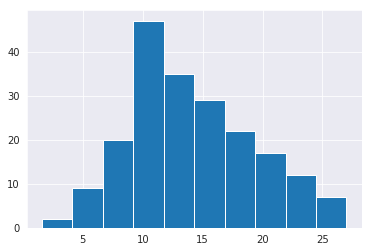

In [8]:
# Distribution of the dependent variable
plt.hist(data['Sales'])

(array([ 1.,  1.,  7., 12., 31., 50., 37., 26., 22., 13.]),
 array([1.26491106, 1.6580352 , 2.05115934, 2.44428347, 2.83740761,
        3.23053174, 3.62365588, 4.01678002, 4.40990415, 4.80302829,
        5.19615242]),
 <a list of 10 Patch objects>)

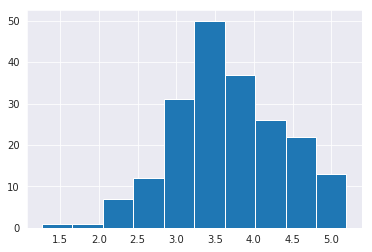

In [9]:
# Distribution of the square root of the dependent variable - more normal
plt.hist(np.sqrt(data['Sales']))

In [10]:
# Add the square root of Sales as an additional feature to the DataFrame
data['sqrt_Sales'] = np.sqrt(data['Sales'])

In [11]:
data.head()

,TV,Radio,Newspaper,Sales,sqrt_Sales
0,230.100,37.800,69.200,22.100,4.701
1,44.500,39.300,45.100,10.400,3.225
2,17.200,45.900,69.300,9.300,3.050
3,151.500,41.300,58.500,18.500,4.301
4,180.800,10.800,58.400,12.900,3.592


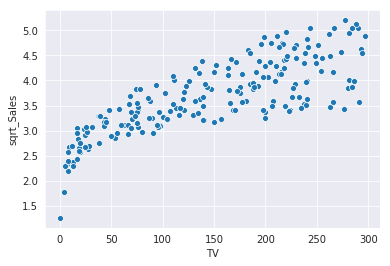

In [12]:
sns.scatterplot(x='TV', y='sqrt_Sales', data=data)
plt.show()

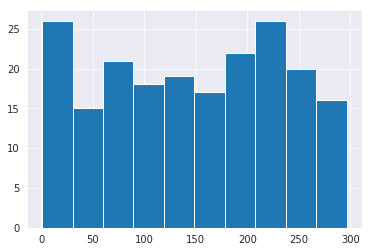

In [13]:
plt.hist(data['TV'])
plt.show()

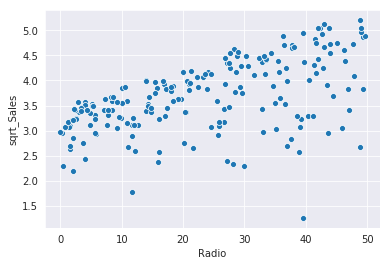

In [14]:
sns.scatterplot(x='Radio', y='sqrt_Sales', data=data)
plt.show()

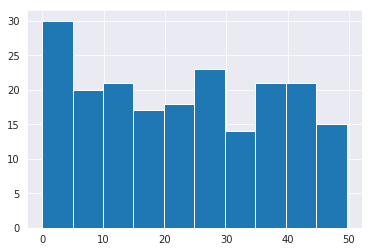

In [15]:
plt.hist(data['Radio'])
plt.show()

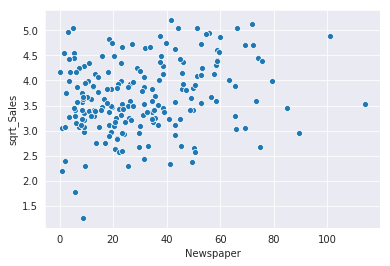

In [16]:
sns.scatterplot(x='Newspaper', y='sqrt_Sales', data=data)
plt.show()

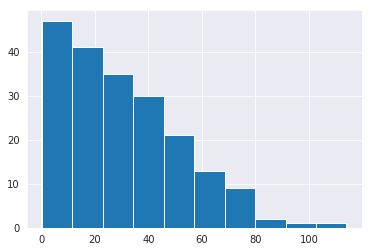

In [17]:
plt.hist(data['Newspaper'])
plt.show()

In [18]:
data['sqrt_Np'] = np.sqrt(data['Newspaper'])

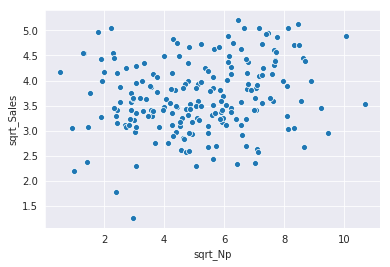

In [19]:
sns.scatterplot(x='sqrt_Np', y='sqrt_Sales', data=data)
plt.show()

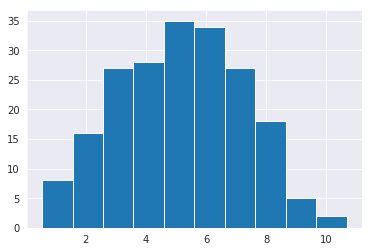

In [20]:
plt.hist(np.sqrt(data['Newspaper']))
plt.show()

In [21]:
# Re-order columns in DataFrame
data = data[['Sales', 'sqrt_Sales', 'TV', 'Radio', 'Newspaper', 'sqrt_Np']]

In [22]:
data.head()

,Sales,sqrt_Sales,TV,Radio,Newspaper,sqrt_Np
0,22.100,4.701,230.100,37.800,69.200,8.319
1,10.400,3.225,44.500,39.300,45.100,6.716
2,9.300,3.050,17.200,45.900,69.300,8.325
3,18.500,4.301,151.500,41.300,58.500,7.649
4,12.900,3.592,180.800,10.800,58.400,7.642


In [23]:
# Check correlation matrix for DataFrame
data.corr()

,Sales,sqrt_Sales,TV,Radio,Newspaper,sqrt_Np
Sales,1.000,0.991,0.782,0.576,0.228,0.205
sqrt_Sales,0.991,1.000,0.796,0.536,0.221,0.202
TV,0.782,0.796,1.000,0.055,0.057,0.046
Radio,0.576,0.536,0.055,1.000,0.354,0.313
Newspaper,0.228,0.221,0.057,0.354,1.000,0.974
sqrt_Np,0.205,0.202,0.046,0.313,0.974,1.000


In [24]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['sqrt_Sales'].values.reshape(-1, 1)
X = data[['TV','Radio', 'sqrt_Np']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[0.00635105 0.02344603 0.00438074]]

Intercept: 
 [2.17527466]

R-squared:
0.8767878079903539


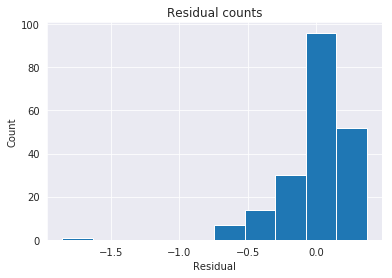

In [25]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['sqrt_Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

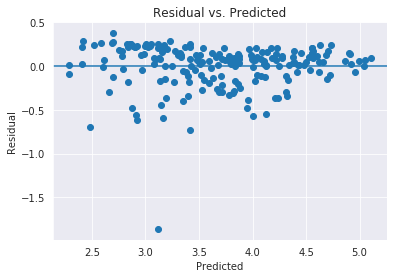

In [26]:
# Data has less heteroscedasticity than before 
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()